In [1]:
import sys
from glob import glob

import time
import h5py
import zarr
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

from datetime import datetime, timedelta

import dask.array as da

In [2]:
lead = 2
print('Batch generation script for lead {}'.format(lead))

Batch generation script for lead 2


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def neighbour_leads(lead):
    out = [lead-2, lead-1, lead, lead+1]
    flag_shift = [0, 0, 0, 0]
    
    for i in range(4):
        if out[i] < 0:
            out[i] = 24+out[i]
            flag_shift[i] = -1
        if out[i] > 23:
            out[i] = out[i]-24
            flag_shift[i] = +1
            
    return out, flag_shift

ind_pick = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22] 
#ind_pick = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22, 23] 

log_norm = [True, False, True, True, True, True, True, True, True, False, False, 
            False, False, True, True, True, True, False, False, False, False, False, False]

sparse = [True, False, True, True, True, True, True, True, True, False, False, 
          False, False, False, True, True, True, False, False, False, False, False, False]

In [5]:
print('Loading HRRR ...')
HRRRv3_lead = zarr.load(save_dir_campaign+'HRRR_{:02}_v3.zarr'.format(lead))
#HRRRv3_lead = da.from_zarr(save_dir_scratch+'HRRR_{:02}_v3.zarr'.format(lead))
print('... done')

Loading HRRR ...
... done


In [14]:
HRRRv3_lead = HRRRv3_lead[:100, ...]

In [6]:
print('Loading observation on lead {} ...'.format(lead))

lead_window, flag_shift = neighbour_leads(lead)

record_all = ()

for i, lead_temp in enumerate(lead_window):
    
    flag_ = flag_shift[i]
    
    with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead_temp), 'r') as h5io:
        record_temp = h5io['record_v3'][...]
        
    if flag_shift[i] == 0:
        record_all = record_all + (record_temp,)
        
    if flag_shift[i] == -1:
        record_temp[1:, ...] = record_temp[:-1, ...]
        record_temp[0, ...] = np.nan
        record_all = record_all + (record_temp,)
    
    if flag_shift[i] == +1:
        record_temp[:-1, ...] = record_temp[1:, ...]
        record_temp[-1, ...] = np.nan
        record_all = record_all + (record_temp,)


shape_record = record_temp.shape      
record_v3 = np.empty(shape_record)
record_v3[...] = np.nan

for i in range(4):
    record_temp = record_all[i]
    for day in range(shape_record[0]):
        for ix in range(shape_record[1]):
            for iy in range(shape_record[2]):
                for event in range(shape_record[3]):
                    if record_temp[day, ix, iy, event] > 0:
                        record_v3[day, ix, iy, event] = 1.0
                    elif record_v3[day, ix, iy, event] == 1.0:
                        record_v3[day, ix, iy, event] = 1.0
                    else:
                        record_v3[day, ix, iy, event] = 0.0

print('... done')

Loading observation on lead 2 ...
... done


In [4]:
print('Loading Geographical information ...')

with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]
    
print('... done')

Loading Geographical information ...
... done


In [5]:
stats = np.load('/glade/work/ksha/NCAR/stats_allv3_80km_full_lead{}{}{}.npy'.format(2, 3, 4))

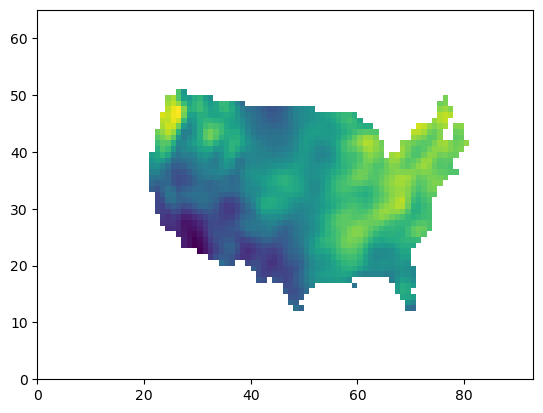

In [6]:
plt.pcolormesh(stats[..., 0, 0])

In [8]:
np.sum(np.isnan(stats[land_mask_80km, 0, 0]))

0

In [38]:


shape_80km = lon_80km.shape
shape_3km = lon_3km.shape
shape_record = record_v3.shape

print('Map 80-km grids to 3-km HRRR domain ...')

indx_array = np.empty(shape_80km)
indy_array = np.empty(shape_80km)

gridTree = cKDTree(list(zip(lon_3km.ravel(), lat_3km.ravel()))) #KDTree_wraper(xgrid, ygrid)

for xi in range(shape_80km[0]):
    for yi in range(shape_80km[1]):
        
        temp_lon = lon_80km[xi, yi]
        temp_lat = lat_80km[xi, yi]
        
        dist, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_3km, indy_3km = np.unravel_index(indexes, shape_3km)
        
        indx_array[xi, yi] = indx_3km[0]
        indy_array[xi, yi] = indy_3km[0]
        
print('... done')

Loading Geographical information ...
... done
Map 80-km grids to 3-km HRRR domain ...
... done


In [19]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

L_train = shape_record[0]

input_size = 64
half_margin = 32

L_vars = len(ind_pick)
L_vars_per = len(ind_pick)

out_slice = np.empty((1, input_size, input_size, L_vars))

batch_dir = '/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/'
prefix = '{}_day{:03d}_{}_{}_{}_indx{}_indy{}_lead{}.npy'

flag_torn = 'neg'
flag_wind = 'neg'
flag_hail = 'neg'

if lead == 2:
    leads = [2, 3, 4]
else:
    leads = [lead-1, lead, lead+1]

norm_stats = np.load('/glade/work/ksha/NCAR/stats_allv3_80km_full_lead{}{}{}.npy'.format(leads[0], leads[1], leads[2]))
max_stats = np.load('/glade/work/ksha/NCAR/p90_allv3_80km_full_lead{}{}{}.npy'.format(leads[0], leads[1], leads[2]))

In [ ]:
print('Generating batches ...')

#L_train = 3
for day in range(L_train):
    if day > 600:
        tv_label = 'VALID'
    else:
        tv_label = 'TRAIN'
        
    for ix in range(shape_80km[0]):
        for iy in range(shape_80km[1]):
            
            indx = int(indx_array[ix, iy])
            indy = int(indy_array[ix, iy])
            
            x_edge_left_ = indx - half_margin
            x_edge_right_ = indx + half_margin
            y_edge_bottom_ = indy - half_margin
            y_edge_top_ = indy + half_margin

            # # indices must be valid
            x_edge_left = x_edge_left_
            y_edge_bottom = y_edge_bottom_
            x_edge_right = x_edge_right_
            y_edge_top = y_edge_top_

            if land_mask_80km[ix, iy]:
                
                # current day HRRR data
                HRRRv3_lead_ = HRRRv3_lead[day, ...]
                
                if x_edge_left_ < 0:
                    delta_x = x_edge_left_
                    x_edge_left = 0
                    x_edge_right = x_edge_right_ - delta_x
                    
                if y_edge_bottom_ < 0:
                    delta_y = y_edge_bottom_
                    y_edge_bottom = 0
                    y_edge_top = y_edge_top_ - delta_y
                    
                if x_edge_right > shape_3km[0]:
                    HRRRv3_lead_ = np.pad(HRRRv3_lead_, ((0, 128), (0, 0), (0, 0)), mode='constant', constant_values=0)
                
                if y_edge_top > shape_3km[1]:
                    HRRRv3_lead_ = np.pad(HRRRv3_lead_, ((0, 0), (0, 128), (0, 0)), mode='constant', constant_values=0)
                
                hrrr_3km = HRRRv3_lead_[x_edge_left:x_edge_right, y_edge_bottom:y_edge_top, :]
                
                means = norm_stats[ix, iy, :, 0]
                stds = norm_stats[ix, iy, :, 1]
                max_vals = max_stats[ix, iy, :, 3]
                
                for v, ind_var in enumerate(ind_pick):

                    temp = hrrr_3km[..., ind_var]

                    if ind_var == 0:
                        temp[temp<0] = 0

                    if ind_var == 16:
                        temp = -1*temp
                        temp[temp<0] = 0

                    if log_norm[ind_var]:
                        temp = np.log(np.abs(temp)+1)

                        if v < 9:
                            temp = temp/stds[v]/max_vals[v]
                        else:
                            temp = 3.0*temp/stds[v]/max_vals[v]

                    else:
                        temp = (temp - means[v])/stds[v]

                    out_slice[..., v] = temp

                if np.sum(np.isnan(out_slice)) > 0:
                    print('nanananannana')
                    continue;

                obs_temp = record_v3[day, ix, iy, :]

                if obs_temp[0] == 0:
                    flag_torn = 'neg'
                else:
                    flag_torn = 'pos'

                if obs_temp[1] == 0:
                    flag_wind = 'neg'
                else:
                    flag_wind = 'pos'

                if obs_temp[2] == 0:
                    flag_hail = 'neg'
                else:
                    flag_hail = 'pos' 

                if np.sum(np.isnan(out_slice)) > 0:
                    print('HRRR contains NaN')
                    continue;
                else:
                    save_name = batch_dir+prefix.format(tv_label, day, flag_torn, flag_wind, flag_hail, ix, iy, lead)
                    print(save_name)
                    #np.save(save_name, out_slice)

print('... done')

Generating batches ...
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx16_indy47_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx16_indy48_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx16_indy70_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx17_indy47_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx17_indy48_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx17_indy69_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx17_indy70_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx18_indy46_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx18_indy47_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN_day000_neg_neg_neg_indx18_indy48_lead2.npy
/glade/campaign/cisl/aiml/ksha/NCAR_b

In [ ]:
HRRRv3_lead = np.pad(HRRRv3_lead, ((0, 0), (128, 128), (128, 128), (0, 0)), 
                     mode='constant', constant_values=0)

/glade/scratch/ksha/ipykernel_120733/3022973668.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon_3km, lat_3km, land_mask_3km, alpha=0.5)
/glade/scratch/ksha/ipykernel_120733/3022973668.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon_80km, lat_80km, land_mask_80km, alpha=0.5)


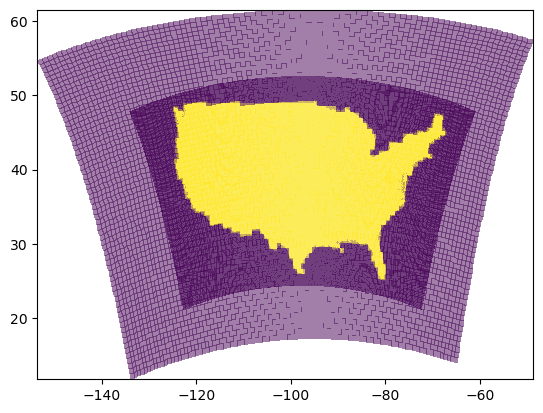

In [39]:
# import pickle

# /glade/work/sobash/NSC_objects/HRRR_new/output_HRRRv4-with-HRRRX
#  ncdump -c predictions_nn_40km_2hr_nn_HRRRv4-with-HRRRX_2021051700.nc
    
# mask  = pickle.load(open('/glade/work/sobash/NSC_objects/HRRR/usamask_mod.pk', 'rb'))
# mask_grid = mask.reshape(65, 93)



# #plt.pcolormesh(lon_80km, lat_80km, mask_grid)
# plt.pcolormesh(lon_3km, lat_3km, land_mask_3km, alpha=0.5)
# plt.pcolormesh(lon_80km, lat_80km, land_mask_80km, alpha=0.5)